<a href="https://colab.research.google.com/github/amiralizadeh1/PINNs/blob/master/KdV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install tensorflow==1.14.0 #TensorFlow version 1 is required. creating equivalent version 2 syntax is troublesome.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109.3 MB 40 kB/s 
     |████████████████████████████████| 488 kB 38.8 MB/s 
     |████████████████████████████████| 3.1 MB 25.5 MB/s 
     |████████████████████████████████| 50 kB 1.4 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.9.2
    Uninstalling tensorflow-2.9.2:
      Successfully uninstalled tensorflow-2.9.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour i

In [ ]:
import tensorflow as tf 
print(tf.__version__) #checking the tf version

1.14.0


In [ ]:
pip install matplotlib==3.2 #just in case that future matplotlib versions change significantly, like tf did.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.4 MB 6.6 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [ ]:
pip install scipy==1.5.2 #just in case that future scipy versions change significantly, like tf did.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 25.9 MB 1.6 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kapre 0.3.7 requires tensorflow>=2.0.0, but you have tensorflow 1.14.0 which is incompatible.


In [ ]:
! sudo apt-get install texlive-latex-recommended #Google Colab coudn't identify latex module. so this code was added according to:
! sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended  #learnsharewithdp.wordpress.com/2020/05/08/latex-matplotlib-google-colab/
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip 
! unzip type1cm.zip -d /tmp/type1cm 
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins
! sudo mkdir /usr/share/texmf/tex/latex/type1cm 
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm 
! sudo texhash

Reading package lists... Done
Building dependency tree       
Reading state information... Done
texlive-latex-recommended is already the newest version (2017.20180305-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 4 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
dvipng is already the newest version (1.15-1).
texlive-fonts-recommended is already the newest version (2017.20180305-1).
texlive-latex-extra is already the newest version (2017.20180305-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 4 not upgraded.
--2022-11-07 13:36:11--  http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip
Resolving mirrors.ctan.org (mirrors.ctan.org)... 5.35.

KeyboardInterrupt: ignored

In [ ]:
!apt install cm-super #according to learnsharewithdp.wordpress.com/2020/05/08/latex-matplotlib-google-colab/

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  cm-super-minimal pfb2t1c2pfb
The following NEW packages will be installed:
  cm-super cm-super-minimal pfb2t1c2pfb
0 upgraded, 3 newly installed, 0 to remove and 4 not upgraded.
Need to get 24.5 MB of archives.
After this operation, 59.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 cm-super-minimal all 0.3.4-11 [5,810 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 pfb2t1c2pfb amd64 0.3-11 [9,342 B]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 cm-super all 0.3.4-11 [18.7 MB]
Fetched 24.5 MB in 1s (31.5 MB/s)
Selecting previously unselected package cm-super-minimal.
(Reading database ... 149820 files and directories 

In [ ]:
from google.colab import drive #add the utilities and data folders to google drive
drive.mount('/content/drive') #and mount it on google colab

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:228: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


It: 0, Loss: 1.026e+04, l1: -0.001, l2: 0.00248, Time: 7.57
It: 10, Loss: 1.017e+04, l1: -0.011, l2: 0.00250, Time: 0.22
It: 20, Loss: 1.014e+04, l1: -0.022, l2: 0.00253, Time: 0.21
It: 30, Loss: 1.003e+04, l1: -0.034, l2: 0.00256, Time: 0.22
It: 40, Loss: 9.538e+03, l1: -0.048, l2: 0.00260, Time: 0.23
It: 50, Loss: 8.021e+03, l1: -0.064, l2: 0.00258, Time: 0.22
It: 60, Loss: 5.683e+03, l1: -0.074, l2: 0.00254, Time: 0.22
It: 70, Loss: 4.989e+03, l1: -0.059, l2: 0.00249, Time: 0.22
It: 80, Loss: 4.595e+03, l1: -0.040, l2: 0.00245, Time: 0.24
It: 90, Loss: 4.510e+03, l1: -0.023, l2: 0.00240, Time: 0.22
It: 100, Loss: 4.422e+03, l1: -0.007, l2: 0.00236, Time: 0.23
It: 110, Loss: 4.337e+03, l1: 0.009, l2: 0.00233, Time: 0.22
It: 120, Loss: 4.245e+03, l1: 0.024, l2: 0.00229, Time: 0.21
It: 130, Loss: 4.132e+03, l1: 0.039, l2: 0.00226, Time: 0.22
It: 140, Loss: 4.004e+03, l1: 0.054, l2: 0.00223, Time: 0.22
It: 150, Loss: 3.892e+03, l1: 0.069, l2: 0.00220, Time: 0.22
It: 160, Loss: 3.802e+03

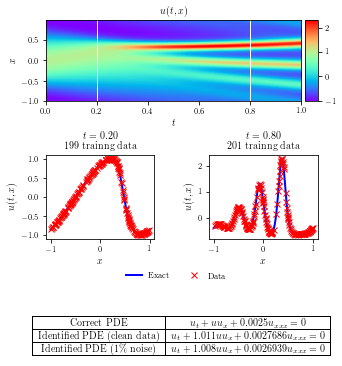

In [8]:
"""
@author: Maziar Raissi
"""

import sys
sys.path.insert(0, '/content/drive/MyDrive/Utilities') #upload utilities folder to your google drive before running the lines

import matplotlib
matplotlib.pyplot.install_repl_displayhook()

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io
from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

np.random.seed(1234)
tf.set_random_seed(1234)


class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, x0, u0, x1, u1, layers, dt, lb, ub, q):
        
        self.lb = lb
        self.ub = ub
        
        self.x0 = x0
        self.x1 = x1
        
        self.u0 = u0
        self.u1 = u1
        
        self.layers = layers
        self.dt = dt
        self.q = max(q,1)
    
        # Initialize NN
        self.weights, self.biases = self.initialize_NN(layers)
        
        # Initialize parameters
        self.lambda_1 = tf.Variable([0.0], dtype=tf.float32)
        self.lambda_2 = tf.Variable([-6.0], dtype=tf.float32)       
        
        # Load IRK weights
        tmp = np.float32(np.loadtxt('../content/drive/MyDrive/Utilities/IRK_weights/Butcher_IRK%d.txt' % (q), ndmin = 2))
        weights =  np.reshape(tmp[0:q**2+q], (q+1,q))     
        self.IRK_alpha = weights[0:-1,:]
        self.IRK_beta = weights[-1:,:]        
        self.IRK_times = tmp[q**2+q:]
        
        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        self.x0_tf = tf.placeholder(tf.float32, shape=(None, self.x0.shape[1]))
        self.x1_tf = tf.placeholder(tf.float32, shape=(None, self.x1.shape[1]))
        self.u0_tf = tf.placeholder(tf.float32, shape=(None, self.u0.shape[1]))
        self.u1_tf = tf.placeholder(tf.float32, shape=(None, self.u1.shape[1]))
        self.dummy_x0_tf = tf.placeholder(tf.float32, shape=(None, self.q)) # dummy variable for fwd_gradients        
        self.dummy_x1_tf = tf.placeholder(tf.float32, shape=(None, self.q)) # dummy variable for fwd_gradients        
        
        self.U0_pred = self.net_U0(self.x0_tf) # N0 x q
        self.U1_pred = self.net_U1(self.x1_tf) # N1 x q
        
        self.loss = tf.reduce_sum(tf.square(self.u0_tf - self.U0_pred)) + \
                    tf.reduce_sum(tf.square(self.u1_tf - self.U1_pred)) 
        
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 1000,
                                                                           'maxfun': 100,
                                                                           'maxcor': 50,
                                                                           #'maxcor': 10,
                                                                           'maxls': 50,
                                                                           #'maxls': 10,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})
                                                                           #'ftol' : 0.01})        
        
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
        
        init = tf.global_variables_initializer()
        self.sess.run(init)
        
    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
    
    def fwd_gradients_0(self, U, x):        
        g = tf.gradients(U, x, grad_ys=self.dummy_x0_tf)[0]
        return tf.gradients(g, self.dummy_x0_tf)[0]
    
    def fwd_gradients_1(self, U, x):        
        g = tf.gradients(U, x, grad_ys=self.dummy_x1_tf)[0]
        return tf.gradients(g, self.dummy_x1_tf)[0]    
    
    def net_U0(self, x):
        lambda_1 = self.lambda_1
        lambda_2 = tf.exp(self.lambda_2)
        U = self.neural_net(x, self.weights, self.biases)        
        U_x = self.fwd_gradients_0(U, x)
        U_xx = self.fwd_gradients_0(U_x, x)
        U_xxx = self.fwd_gradients_0(U_xx, x)        
        F = -lambda_1*U*U_x - lambda_2*U_xxx
        U0 = U - self.dt*tf.matmul(F, self.IRK_alpha.T)
        return U0
    
    def net_U1(self, x):
        lambda_1 = self.lambda_1
        lambda_2 = tf.exp(self.lambda_2)
        U = self.neural_net(x, self.weights, self.biases)        
        U_x = self.fwd_gradients_1(U, x)
        U_xx = self.fwd_gradients_1(U_x, x)
        U_xxx = self.fwd_gradients_1(U_xx, x)        
        F = -lambda_1*U*U_x - lambda_2*U_xxx
        U1 = U + self.dt*tf.matmul(F, (self.IRK_beta - self.IRK_alpha).T)
        return U1

    def callback(self, loss):
        print('Loss:', loss)
    
    def train(self, nIter):
        tf_dict = {self.x0_tf: self.x0, self.u0_tf: self.u0, 
                   self.x1_tf: self.x1, self.u1_tf: self.u1,
                   self.dummy_x0_tf: np.ones((self.x0.shape[0], self.q)),
                   self.dummy_x1_tf: np.ones((self.x1.shape[0], self.q))}
                           
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            ###tf.train.AdamOptimizer.minimize(loss)
            
            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                lambda_1_value = self.sess.run(self.lambda_1)
                lambda_2_value = np.exp(self.sess.run(self.lambda_2))
                print('It: %d, Loss: %.3e, l1: %.3f, l2: %.5f, Time: %.2f' % 
                      (it, loss_value, lambda_1_value, lambda_2_value, elapsed))
                start_time = time.time()
        
        self.optimizer.minimize(self.sess,
                                feed_dict = tf_dict,
                                fetches = [self.loss],
                                loss_callback = self.callback)
                                #loss_callback = None)
        ###tf.contrib.opt.ScipyOptimizerInterface(loss,method='L-BFGS-B',option='maxiter': 1000).minimize(session=None, feed_dict=None, fetches=None, step_callback=None, loss_callback=None, **run_kwargs)

#session:	A Session instance.
#feed_dict:	A feed dict to be passed to calls to session.run.
#fetches:	A list of Tensors to fetch and supply to loss_callback as positional arguments.
#step_callback:	A function to be called at each optimization step; arguments are the current values of all optimization variables flattened into a single vector.
#loss_callback	A function to be called every time the loss and gradients are computed, with evaluated fetches supplied as positional arguments.
#**run_kwargs	kwargs to pass to session.run.
    
    def predict(self, x_star):
        
        U0_star = self.sess.run(self.U0_pred, {self.x0_tf: x_star, self.dummy_x0_tf: np.ones((x_star.shape[0], self.q))})        
        U1_star = self.sess.run(self.U1_pred, {self.x1_tf: x_star, self.dummy_x1_tf: np.ones((x_star.shape[0], self.q))})
                    
        return U0_star, U1_star

    
if __name__ == "__main__": 
        
    q = 50
    skip = 120

    N0 = 199
    N1 = 201
    layers = [1, 50, 50, 50, 50, q]
    
    data = scipy.io.loadmat('../content/drive/MyDrive/Data/KdV.mat')
    
    t_star = data['tt'].flatten()[:,None]
    x_star = data['x'].flatten()[:,None]
    Exact = np.real(data['uu'])
    
    idx_t = 40
        
    ######################################################################
    ######################## Noiseles Data ###############################
    ######################################################################
    noise = 0.0    
    
    idx_x = np.random.choice(Exact.shape[0], N0, replace=False)
    x0 = x_star[idx_x,:]
    u0 = Exact[idx_x,idx_t][:,None]
    u0 = u0 + noise*np.std(u0)*np.random.randn(u0.shape[0], u0.shape[1])
        
    idx_x = np.random.choice(Exact.shape[0], N1, replace=False)
    x1 = x_star[idx_x,:]
    u1 = Exact[idx_x,idx_t + skip][:,None]
    u1 = u1 + noise*np.std(u1)*np.random.randn(u1.shape[0], u1.shape[1])
    
    dt = np.asscalar(t_star[idx_t+skip] - t_star[idx_t])        
        
    # Doman bounds
    lb = x_star.min(0)
    ub = x_star.max(0)

    model = PhysicsInformedNN(x0, u0, x1, u1, layers, dt, lb, ub, q)
    model.train(nIter = 1000)
    #model.train(nIter = 000)
    
    U0_pred, U1_pred = model.predict(x_star)    
        
    lambda_1_value = model.sess.run(model.lambda_1)
    lambda_2_value = np.exp(model.sess.run(model.lambda_2))
                
    error_lambda_1 = np.abs(lambda_1_value - 1.0)/1.0 *100
    error_lambda_2 = np.abs(lambda_2_value - 0.0025)/0.0025 * 100
    
    print('Error lambda_1: %f%%' % (error_lambda_1))
    print('Error lambda_2: %f%%' % (error_lambda_2))
    
    
    ######################################################################
    ########################### Noisy Data ###############################
    ######################################################################
    noise = 0.01        
    
    u0 = u0 + noise*np.std(u0)*np.random.randn(u0.shape[0], u0.shape[1])
    u1 = u1 + noise*np.std(u1)*np.random.randn(u1.shape[0], u1.shape[1])
    
    model = PhysicsInformedNN(x0, u0, x1, u1, layers, dt, lb, ub, q)    
    model.train(nIter = 1000)
    #model.train(nIter = 000)
    
    U_pred = model.predict(x_star)
    
    U0_pred, U1_pred = model.predict(x_star)    
        
    lambda_1_value_noisy = model.sess.run(model.lambda_1)
    lambda_2_value_noisy = np.exp(model.sess.run(model.lambda_2))
                
    error_lambda_1_noisy = np.abs(lambda_1_value_noisy - 1.0)/1.0 *100
    error_lambda_2_noisy = np.abs(lambda_2_value_noisy - 0.0025)/0.0025 * 100
    
    print('Error lambda_1: %f%%' % (error_lambda_1_noisy))
    print('Error lambda_2: %f%%' % (error_lambda_2_noisy))
    
    ######################################################################
    ############################# Plotting ###############################
    ######################################################################
    
    fig, ax = newfig(1.0, 1.5)
    ax.axis('off')
    
    gs0 = gridspec.GridSpec(1, 2)
    gs0.update(top=1-0.06, bottom=1-1/3+0.05, left=0.15, right=0.85, wspace=0)
    ax = plt.subplot(gs0[:, :])
        
    h = ax.imshow(Exact, interpolation='nearest', cmap='rainbow',
                  extent=[t_star.min(),t_star.max(), lb[0], ub[0]],
                  origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    
    line = np.linspace(x_star.min(), x_star.max(), 2)[:,None]
    ax.plot(t_star[idx_t]*np.ones((2,1)), line, 'w-', linewidth = 1.0)
    ax.plot(t_star[idx_t + skip]*np.ones((2,1)), line, 'w-', linewidth = 1.0)    
    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.set_title('$u(t,x)$', fontsize = 10)
    
    gs1 = gridspec.GridSpec(1, 2)
    gs1.update(top=1-1/3-0.1, bottom=1-2/3, left=0.15, right=0.85, wspace=0.5)

    ax = plt.subplot(gs1[0, 0])
    ax.plot(x_star,Exact[:,idx_t][:,None], 'b', linewidth = 2, label = 'Exact')
    ax.plot(x0, u0, 'rx', linewidth = 2, label = 'Data')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t,x)$')
    ax.set_title('$t = %.2f$\n%d trainng data' % (t_star[idx_t], u0.shape[0]), fontsize = 10)
    
    ax = plt.subplot(gs1[0, 1])
    ax.plot(x_star,Exact[:,idx_t + skip][:,None], 'b', linewidth = 2, label = 'Exact')
    ax.plot(x1, u1, 'rx', linewidth = 2, label = 'Data')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t,x)$')
    ax.set_title('$t = %.2f$\n%d trainng data' % (t_star[idx_t+skip], u1.shape[0]), fontsize = 10)
    ax.legend(loc='upper center', bbox_to_anchor=(-0.3, -0.3), ncol=2, frameon=False)
    
    gs2 = gridspec.GridSpec(1, 2)
    gs2.update(top=1-2/3-0.05, bottom=0, left=0.15, right=0.85, wspace=0.0)
    
    ax = plt.subplot(gs2[0, 0])
    ax.axis('off')
    s1 = r'$\begin{tabular}{ |c|c| }  \hline Correct PDE & $u_t + u u_x + 0.0025 u_{xxx} = 0$ \\  \hline Identified PDE (clean data) & '
    s2 = r'$u_t + %.3f u u_x + %.7f u_{xxx} = 0$ \\  \hline ' % (lambda_1_value, lambda_2_value)
    s3 = r'Identified PDE (1\% noise) & '
    s4 = r'$u_t + %.3f u u_x + %.7f u_{xxx} = 0$  \\  \hline ' % (lambda_1_value_noisy, lambda_2_value_noisy)
    s5 = r'\end{tabular}$'
    s = s1+s2+s3+s4+s5
    ax.text(-0.1,0.2,s)

    #savefig('./figures/KdV') 